In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_file_path = '/content/drive/My Drive/archive (1).zip'
destination_folder = '/content/Retina_blood_vessel'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Extracted files to: {destination_folder}")


Extracted files to: /content/Retina_blood_vessel


In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, images_folder, masks_folder, transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.transform = transform
        self.image_list = os.listdir(images_folder)
        self.mask_list = os.listdir(masks_folder)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_folder, self.image_list[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_list[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # assuming masks are grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = self.up_conv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = self.up_conv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = self.up_conv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = self.up_conv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return torch.sigmoid(self.final_conv(dec1))


In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
batch_size = 4
learning_rate = 1e-3
num_epochs = 20
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
train_dataset = SegmentationDataset('/content/Retina_blood_vessel/Data/train/image', '/content/Retina_blood_vessel/Data/train/mask', transform=transform)
test_dataset = SegmentationDataset('/content/Retina_blood_vessel/Data/test/image', '/content/Retina_blood_vessel/Data/test/mask', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.float()
        masks = masks.float()
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')


Epoch [1/20], Loss: 0.4512
Epoch [2/20], Loss: 0.3263
Epoch [3/20], Loss: 0.2566
Epoch [4/20], Loss: 0.2188
Epoch [5/20], Loss: 0.1969
Epoch [6/20], Loss: 0.1844
Epoch [7/20], Loss: 0.1736
Epoch [8/20], Loss: 0.1700
Epoch [9/20], Loss: 0.1616
Epoch [10/20], Loss: 0.1571
Epoch [11/20], Loss: 0.1527
Epoch [12/20], Loss: 0.1505
Epoch [13/20], Loss: 0.1495
Epoch [14/20], Loss: 0.1457
Epoch [15/20], Loss: 0.1431
Epoch [16/20], Loss: 0.1430
Epoch [17/20], Loss: 0.1416
Epoch [18/20], Loss: 0.1393
Epoch [19/20], Loss: 0.1382
Epoch [20/20], Loss: 0.1386


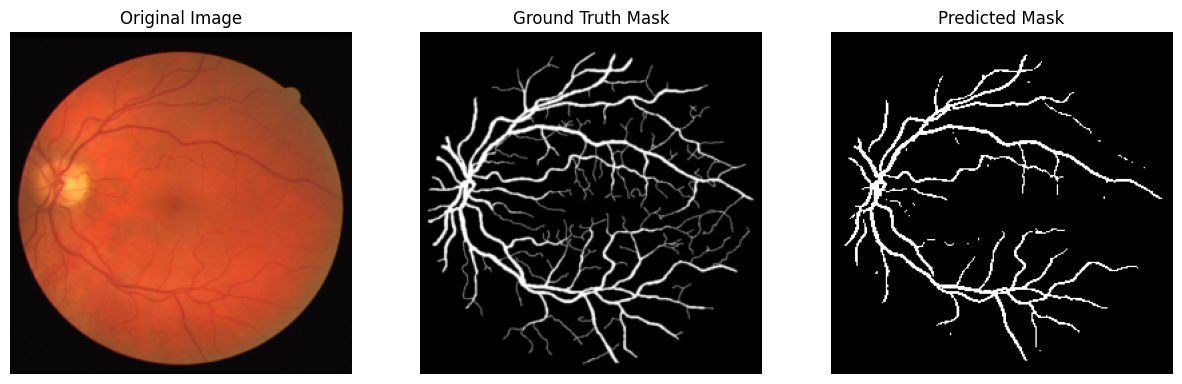

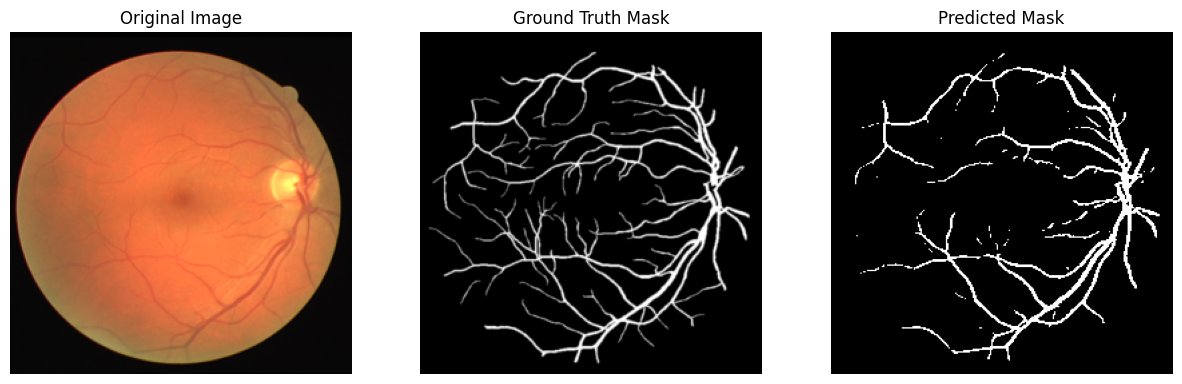

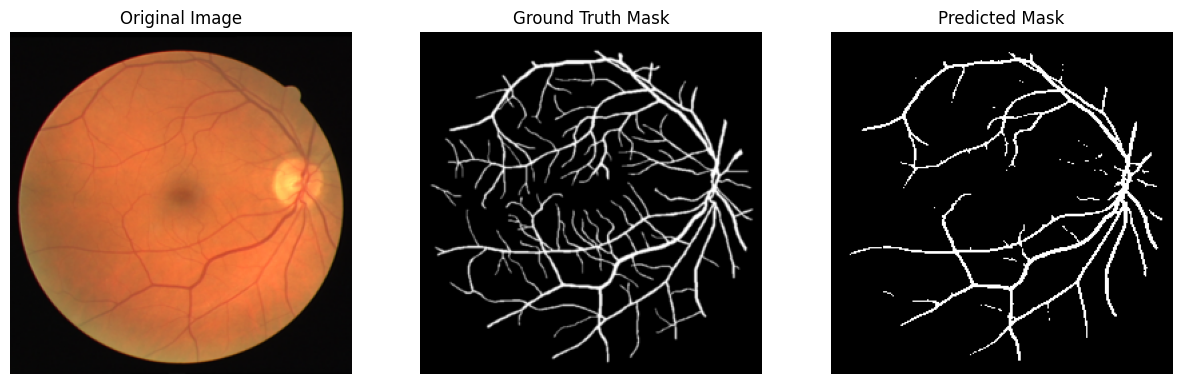

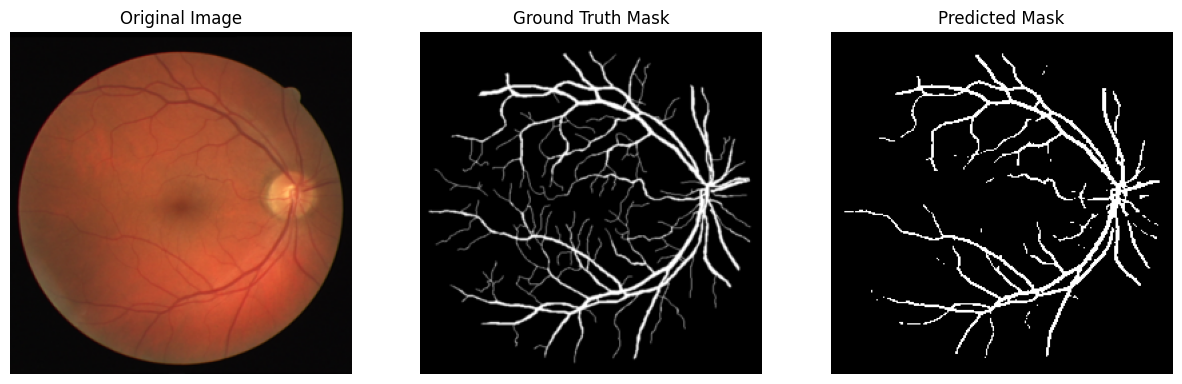

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_results(images, masks, outputs):
    images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks_np = masks.cpu().numpy().transpose(0, 2, 3, 1)
    outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
    batch_size = images_np.shape[0]
    for i in range(batch_size):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images_np[i])
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        ax[1].imshow(masks_np[i].squeeze(), cmap='gray')
        ax[1].set_title("Ground Truth Mask")
        ax[1].axis("off")
        predicted_mask = outputs_np[i].squeeze() > 0.5
        ax[2].imshow(predicted_mask, cmap='gray')
        ax[2].set_title("Predicted Mask")
        ax[2].axis("off")
        plt.show()

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.float()
        masks = masks.float()
        outputs = model(images)
        visualize_results(images, masks, outputs)
        break
